# Install chainer

In [35]:
!pip install chainer
!pip install chainercv
!pip install matplotlib

In [36]:
import chainer
import cupy
import chainercv
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
from PIL import Image
%matplotlib inline
import os

chainer.print_runtime_info()
print('ChainerCV:', chainercv.__version__)
print('matplotlib:', matplotlib.__version__)

Platform: Linux-4.9.0-8-amd64-x86_64-with-debian-9.5
Chainer: 6.1.0
NumPy: 1.16.4
CuPy:
  CuPy Version          : 6.1.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7500
  cuDNN Version         : 7500
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: Not Available
ChainerCV: 0.13.1
matplotlib: 3.0.0


## Data location

In [37]:
print(os.listdir("../input"))

['depths.csv', 'train', 'train.csv', 'sample_submission.csv', 'test']


## Check data type & shape

uint8
(101, 101, 3)
int32
(101, 101)


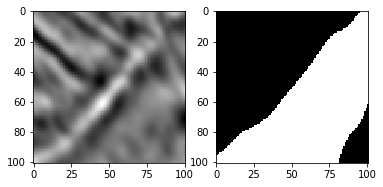

In [38]:
folder="../input/"
img = np.asarray(Image.open(folder + 'train/images/0c02f95a08.png'))
print(img.dtype)
print(img.shape)

label = np.asarray(Image.open(folder + 'train/masks/0c02f95a08.png'))
print(label.dtype)
print(label.shape)


fig, axes = plt.subplots(1,2)
axes[0].imshow(img, cmap='gray')
axes[1].imshow(label, cmap='gray')

## Import train.csv and depth.csv

In [40]:
#Lets Create a class to represent our dataset
class TGSSaltDataset():
  def __init__(self, root_path, file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(self.file_list)
  
  def __getitem__(self, index):
    file_id = self.file_list[index]
    #image folder + path
    image_folder = os.path.join(self.root_path, 'images')
    image_path = os.path.join(image_folder, file_id + '.png')
    
    #mask folder + path
    mask_folder = os.path.join(self.root_path, 'masks')
    mask_path = os.path.join(mask_folder, file_id + '.png')
    
    #read it
    image = np.array(imageio.imread(image_path), dtype=np.uint8)
    mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
    
    return image, mask

In [41]:
train_mask = pd.read_csv(folder + 'train.csv')
depth = pd.read_csv(folder + 'depths.csv')

train_path = "../input/train/"

file_list = list(train_mask['id'].values)
dataset = TGSSaltDataset(train_path, file_list)  

## Define plot

In [42]:
#function to visualize th eimages
def plot2x2array(image, mask):
  #invoke matplotlib!
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask, cmap='gray')
  axarr[0].grid()
  axarr[1].grid()
  axarr[0].set_title('Image')
  axarr[1].set_title('Mask')
  #axarr[0].axis('off')
  #axarr[1].axis('off')

## Plot 5 Image and Mask randomly

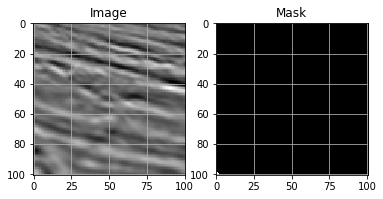

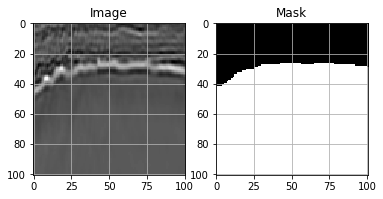

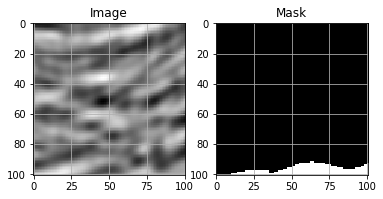

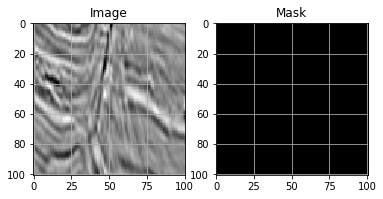

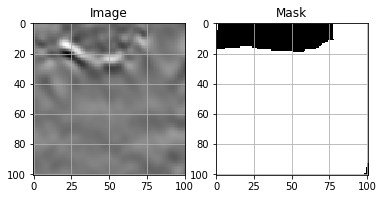

In [44]:
#print the image
for i in range(5):
  image, mask = dataset[np.random.randint(0,len(dataset))]
  plot2x2array(image, mask)

## Depth distribution

Text(0.5, 1.0, 'depth disributiont')

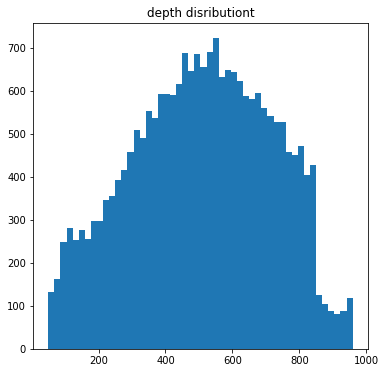

In [45]:
#plot the distribution of depths
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins=50)
plt.title('depth disributiont')

## Define Run length encoding (rle) to Image

In [46]:
#convert run length encoding to images that can be input into our model
def rleToMask(rleString, height, width):
  #width, height
  #from IPython.core.debugger import Pdb; Pdb().set_trace()
  rows, cols = height, width
  try:
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols, dtype=np.uint8)
    for index, length in rlePairs:
      index -=1
      img[index:index+length] = 255
      
    img = img.reshape(cols, rows)
    img = img.T
    
  except:
    img = np.zeros((cols, rows))
    
  return img  

In [47]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x,101,101))
train_mask.head(2)

,id,rle_mask,mask
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## Salt portion (# Salt pixel/10201)

In [48]:
#function for measureing how salty an image is
def salt_proportion(imgArray):
  try:
    unique, counts = np.unique(imgArray, return_counts=True)
    return counts[1]/10201.
  
  except:
    return 0.0

In [49]:
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))
train_mask.head(2)

,id,rle_mask,mask,salt_proportion
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00000
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.50495


## Salt portion histogram
[0.0 - 0.1], [0.1 - 0.2],...

(array([2137.,  297.,  224.,  185.,  226.,  205.,  174.,  148.,  159.,
         245.]),
 array([0.        , 0.0999902 , 0.19998039, 0.29997059, 0.39996079,
        0.49995099, 0.59994118, 0.69993138, 0.79992158, 0.89991177,
        0.99990197]),
 <a list of 10 Patch objects>)

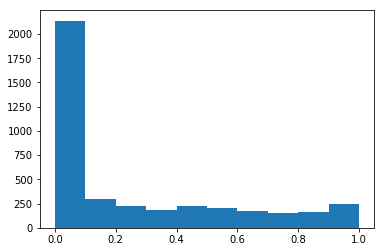

In [50]:
plt.hist(train_mask['salt_proportion'], bins=10)

## Converge_class
* class 0: Salt portion   = 0.0 (No Salt)
* class 1: Salt portion <= 0.1
* class 2: Salt portion <= 0.2
* ....
* class 10: Salt portion <= 1.0

In [51]:
def cov_to_class(val):
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_mask["coverage_class"] = train_mask.salt_proportion.map(cov_to_class)
train_mask.head(2)

,id,rle_mask,mask,salt_proportion,coverage_class
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00000,0
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.50495,6


(array([1562.,  576.,  296.,  224.,  186.,  225.,  205.,  174.,  148.,
         404.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

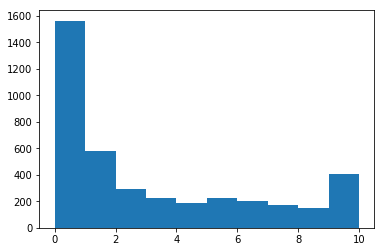

In [52]:
plt.hist(train_mask['coverage_class'])

In [53]:
#add depth
merged = train_mask.merge(depth, how ='left')
merged.head(2)

,id,rle_mask,mask,salt_proportion,coverage_class,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.00000,0,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.50495,6,794


## Proportion of salt vs Depth

Text(0.5, 1.0, 'Proportion of salt vs depth')

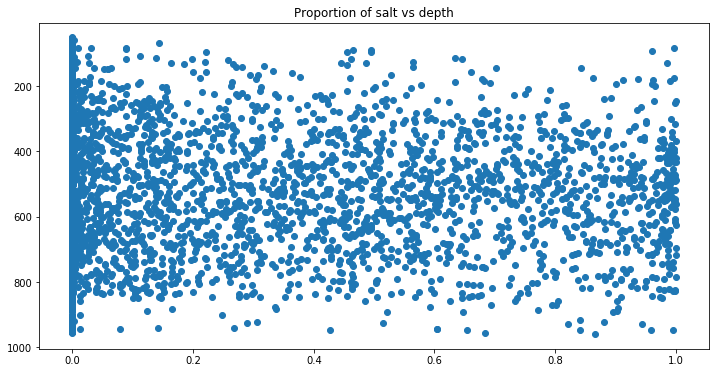

In [54]:
#show proportion of salt vs depth
plt.figure(figsize=(12,6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.gca().invert_yaxis()
plt.title('Proportion of salt vs depth')

## Dataset (Class >=2)

In [55]:
merged_new = merged[merged.coverage_class >=2]
print(len(merged_new))
merged_new.head(2)

1862


,id,rle_mask,mask,salt_proportion,coverage_class,z
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,6,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,10,468


## train, valid data

In [62]:
from sklearn.model_selection import train_test_split
ids_train, ids_valid = train_test_split(merged_new.id.values, test_size=0.2, stratify=merged_new.coverage_class, random_state=1338)

#ids_train=ids_train[0:100]
#ids_valid=ids_valid[0:20]
print("train=%d" % len(ids_train))
print("valid=%d" % len(ids_valid))

img_train = list('../input/train/images/' + ids_train + ".png")
mask_train = list('../input/train/masks/' + ids_train + ".png")

img_valid = list('../input/train/images/' + ids_valid + ".png")
mask_valid = list('../input/train/masks/' + ids_valid + ".png")

train=1489
valid=373


## Make Dataset for DL

In [76]:
from chainer import dataset
from PIL import Image

class DATASETtoGRAY(dataset.DatasetMixin):
  def __init__(self, values, mask = False):
    self.values = values
    self.mask = mask
  def __len__(self):
    return len(self.values)
  def get_example(self, i):
    if self.mask:
      img = np.asarray(Image.open(self.values[i]), dtype=np.int32)
      img = img / 65535.
      img = img[None, ...]
      img = img.astype(np.int32)
      return img
    else:
      img = np.asarray(Image.open(self.values[i]), dtype=np.float32)[:,:,0:1]
      img = img / 255.
      img = img.transpose(2,0,1) # PIL(height, width, channel)
      return img

In [64]:
train_dataset = DATASETtoGRAY(img_train)
train_masks = DATASETtoGRAY(mask_train, mask = True)
valid_dataset = DATASETtoGRAY(img_valid)
valid_masks = DATASETtoGRAY(mask_valid, mask = True)
#print("train shape", train_dataset[1].shape)
#print("mask shape", train_masks[1].shape)

from chainer import datasets
train = datasets.TupleDataset(train_dataset, train_masks)
valid = datasets.TupleDataset(valid_dataset, valid_masks)

## plot train data

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


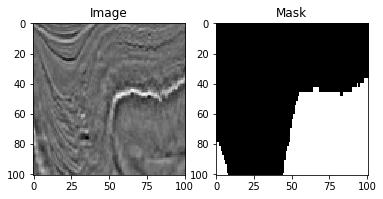

In [66]:
import matplotlib.pyplot as plt
n=2
plt, ax = plt.subplots(1,2)
ax[0].imshow(train[n][0][0], cmap='gray')
ax[1].imshow(train[n][1][0], cmap='gray')
ax[0].set_title('Image')
ax[1].set_title('Mask')
plt.show()

## Library

In [104]:
import chainer.functions as F
import chainer.links as L
from chainer import reporter
from chainer import cuda
from chainercv import evaluations
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

## Fully Convolution Network

In [80]:
FIXME_1 = 64
FIXME_2 = 128
FIXME_3 = 128
FIXME_4 = 128
FIXME_5 = 128

class FullyConvolutionalNetwork(chainer.Chain):

    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, FIXME_1, ksize=5, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, FIXME_2, ksize=5, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, FIXME_3, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, FIXME_4, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, FIXME_5, ksize=1, stride=1, pad=0)
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=27, stride=15, pad=8)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

#print(FullyConvolutionalNetwork(101, 101)(np.zeros((1, 1, 101, 101), dtype=np.float32)).shape[2:])

In [81]:
class PixelwiseSigmoidClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x, t):
        y = self.predictor(x)

        loss = F.sigmoid_cross_entropy(y, t)
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

In [82]:
def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=101, out_w=101)
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = ['epoch', 'main/loss', 'main/miou', 'main/pa','val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer

## 10 epoch

In [83]:
%%time
trainer = create_trainer(64, train, valid, (10, 'epoch'), device=0, log_trigger=(1, 'epoch'))
trainer.run()

epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
1           0.692242    0.360204    0.544827    0.692251       0.353506       0.537989     
2           0.690302    0.292879    0.511191    0.651658       0.497939       0.666916     
3           0.655117    0.398481    0.589604    0.60562        0.541828       0.705436     
4           0.54936     0.609933    0.759176    0.522841       0.604368       0.755539     
5           0.527736    0.582514    0.748902    0.476032       0.632239       0.777268     
6           0.612599    0.470656    0.660113    0.601286       0.49389        0.664209     
7           0.464982    0.65695     0.796494    0.472017       0.626341       0.771931     
8           0.424264    0.67209     0.805839    0.398289       0.695033       0.820174     
9           0.391026    0.696806    0.821638    0.361767       0.716939       0.835344     
10          0.332229    0.739888    0.850565    0.336384       0.743183       0.85

Loss


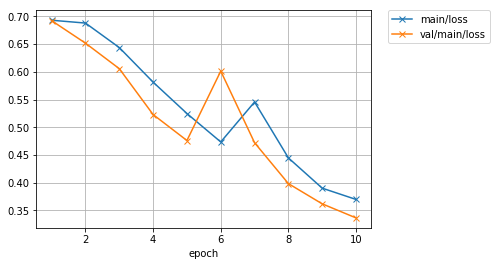

In [84]:
from IPython.display import Image
print('Loss')
Image('result_fcn/loss.png')

Pixel Accuracy


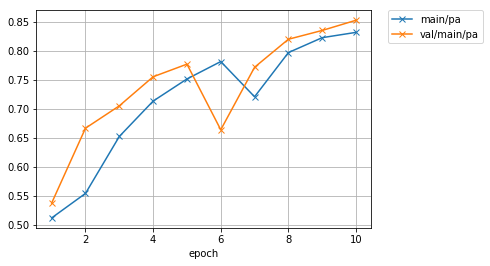

In [86]:
print('Pixel Accuracy')
Image('result_fcn/pa.png')

mean IoU


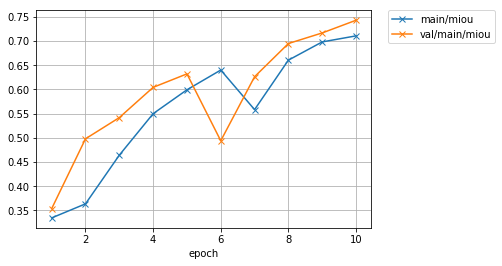

In [85]:
print('mean IoU')
Image('result_fcn/miou.png')

In [ ]:
from PIL import Image

def evaluate(trainer, val, device=-1):
    model = trainer.updater.get_optimizer('main').target.predictor

    preds = []
    for img, label in val:
        img = cuda.to_gpu(img[np.newaxis], device)
        pred = model(img)
        pred = cuda.to_cpu(pred.data[0, 0] > 0)
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])
    
evaluate(trainer, valid, device=0)

Pixel Accuracy: 0.8523298325638579
mIoU: 0.7425595124390247


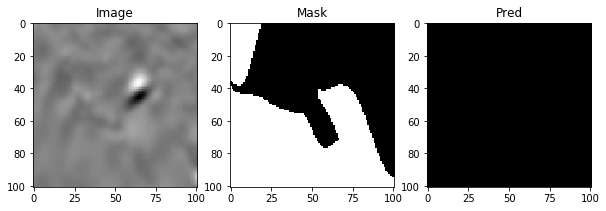

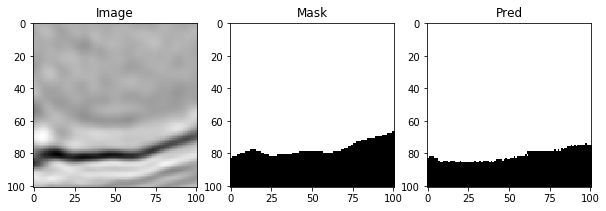

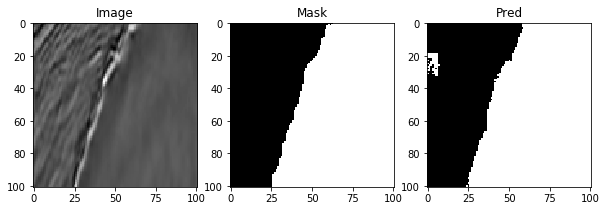

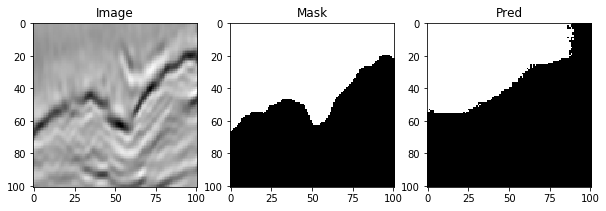

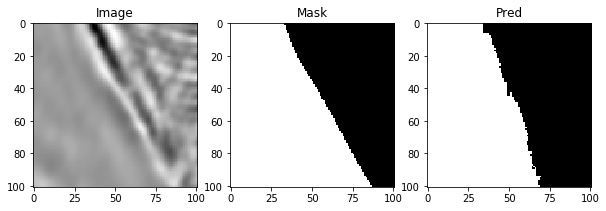

In [102]:
import matplotlib.pyplot as plt

def show_predicts(trainer, val, device=-1, n_sample=1):
    model = trainer.updater.get_optimizer('main').target.predictor

    for i in range(n_sample):
        img, label = val[i]
        img = cuda.to_gpu(img, device)
        pred = model(img[np.newaxis])
        pred = cuda.to_cpu(pred.data[0, 0] > 0)        
        fig, ax = plt.subplots(1, 3, figsize=(10, 10))
        
        #ax[0].set_axis_off()
        ax[0].imshow(cuda.to_cpu(img[0]), cmap='gray')
        ax[0].set_title('Image')
        
        #ax[1].set_axis_off()
        ax[1].imshow(label[0], cmap='gray')
        ax[1].set_title('Mask')

        #ax[2].set_axis_off()
        ax[2].imshow(pred, cmap='gray')
        ax[2].set_title('Pred')

        plt.show()
        
show_predicts(trainer, valid, device=0, n_sample=5)

# Option

## test data 18000

In [105]:
import glob
test_img_dirc = sorted(glob.glob('../input/test/images/*.png'))

test = DATASETtoGRAY(test_img_dirc)

## Predict test data

In [109]:
from tqdm import tqdm_notebook
model = trainer.updater.get_optimizer('main').target.predictor

preds = []

for img, value in zip(tqdm_notebook(test),test.values):   
    img = cuda.to_gpu(img[np.newaxis], 0)
    pred = model(img)
    pred = cuda.to_cpu(pred.data[0, 0] > 0)
    ids = os.path.split(value)[1].split('.')[0]
    preds.append((ids, pred))
    

## Check test data

Text(0.5, 1.0, '000a68e46c.png')

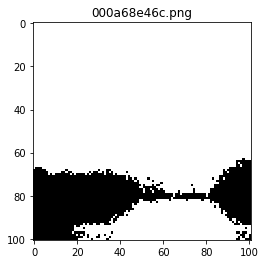

In [121]:
t=1
plt.imshow(preds[t][1], cmap="gray")
plt.title(preds[t][0]+".png")

## Convert to rle (run length encoding)

In [122]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not
    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [123]:
pred_dict = {ids: RLenc(j) for ids, j in tqdm_notebook(preds)}

In [124]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')